## TFG MANEL

### Petita exploració de wordnet, com funciona, com es relaciona, com es l'estructura jerarquica.

1. Importació de llibreries

In [1]:
import nltk
from nltk.corpus import wordnet as wn
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os

#### Arbre del wordnet
- Es tracta d'un DAG, graf dirigit aciclic. No hi ha un camí que comenci i acabi en el mateix lloc

#### L'estructura del wordnet es basa en synsets

- Synset = Conjunt de sinònims representats per un d'ells, que té un significat únic. (Unitat Base de wordnet/imagenet)
- Un node recopila tots els sinònims d'aquella paraula dintre del mateix context, dog --> gos, dog --> perrito caliente, difs contexts
-  Cada node de l'arbre és un synset que es relaciona amb altres synsets en forma d'hiponims o hyperonims

#### L'estructura del synsets
- Cada sysnset es representa com : ParaulaClau.TipusParaula.Significat.
- Paraula Base : Paraula que reciopila tota la informació, tots el sinonims. Paraula Representativa
- Tipus de Paraula : Noun, Verb, Adjective, Adverb, etc
- Significat :Numero que identifica els diferents significats d'una paraula que s'escriu igual (paraules homonimes)
ex: dog i dog dog.n.01 = gos, dog.n.02 = perrito caliente

#### Informació dintre del synset
- Nom
- Definició
- Exemples
- Sinònims

#### Hyperonims i Hyponims
- Hyperonims: Són les paraules que tenen un significat més general 
- Hyponims: Són les paraules que tenen un significat més específic
ex: Animal --> gos, gat, etc. (Animal es un hyperonim de gos)
- Per a navegar per l'arbre anirem escalant per hyperonims fins a trobar el hyperonim general per a les paraules

#### Meronyms i Holonims
- Meronyms: Parts d'un concepte , ex : Cotxe --> Roda
- Holonims: Conceptes que estan compostos per meronyms, ex : Roda --> Cotxe

#### Objetivo: 
- Encontrar aquel concepto general que relacione los difernetes top scores de cada una de las neuronas de una capa

#### LCA: Least Common Ancestor
- Conjunto mas general para el conjunto de etiquetas

## COMENÇA L'EXPLORACIÓ

Print de la informació d'un sysnset

In [2]:
dog = wn.synset('dalmatian.n.02')
# Información básica del Synset
print("Nombre del Synset:", dog.name())
print("Definición:", dog.definition())
print("Ejemplos de uso:", dog.examples())
print("Sinónimos:", dog.lemma_names())

Nombre del Synset: dalmatian.n.02
Definición: a large breed having a smooth white coat with black or brown spots; originated in Dalmatia
Ejemplos de uso: []
Sinónimos: ['dalmatian', 'coach_dog', 'carriage_dog']


Hypernims i hyponims

In [3]:
# Obtener los hypernyms de "dog.n.01"
hypernyms = dog.hypernyms()
print("Hypernyms (conceptos más generales):", [h.name() for h in hypernyms])
# Obtener los hyponyms de "dog.n.01"
hyponyms = dog.hyponyms()
print("Hyponyms (conceptos más específicos):", [h.name() for h in hyponyms])

Hypernyms (conceptos más generales): ['dog.n.01']
Hyponyms (conceptos más específicos): ['liver-spotted_dalmatian.n.01']


LCA de dos exemples: gat i gos

In [4]:
# Synsets de "dog" y "cat"
dog = wn.synset('dog.n.01')
cat = wn.synset('cat.n.01')

# Obtener el ancestro común más cercano
lca = dog.lowest_common_hypernyms(cat)
print("Ancestro común más cercano:", lca[0].name(), "-", lca[0].definition())


Ancestro común más cercano: carnivore.n.01 - a terrestrial or aquatic flesh-eating mammal


Obtenir tot el camí, amb la descripció de cada pas

In [5]:
# Obtener las rutas hacia la raíz para "dog.n.01" y "cat.n.01"
dog_paths = dog.hypernym_paths()
cat_paths = cat.hypernym_paths()

# Imprimir rutas
print("Ruta de 'dog.n.01':")
for synset in dog_paths[0]:
    print(f"  {synset.name()} - {synset.definition()}")

print("\nRuta de 'cat.n.01':")
for synset in cat_paths[0]:
    print(f"  {synset.name()} - {synset.definition()}")


Ruta de 'dog.n.01':
  entity.n.01 - that which is perceived or known or inferred to have its own distinct existence (living or nonliving)
  physical_entity.n.01 - an entity that has physical existence
  object.n.01 - a tangible and visible entity; an entity that can cast a shadow
  whole.n.02 - an assemblage of parts that is regarded as a single entity
  living_thing.n.01 - a living (or once living) entity
  organism.n.01 - a living thing that has (or can develop) the ability to act or function independently
  animal.n.01 - a living organism characterized by voluntary movement
  chordate.n.01 - any animal of the phylum Chordata having a notochord or spinal column
  vertebrate.n.01 - animals having a bony or cartilaginous skeleton with a segmented spinal column and a large brain enclosed in a skull or cranium
  mammal.n.01 - any warm-blooded vertebrate having the skin more or less covered with hair; young are born alive except for the small subclass of monotremes and nourished with milk

In [6]:
# Listar todos los Synsets de "dog"
dog_synsets = wn.synsets('dog')
for synset in dog_synsets:
    print(f"{synset.name()} - {synset.definition()}")


dog.n.01 - a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric times; occurs in many breeds
frump.n.01 - a dull unattractive unpleasant girl or woman
dog.n.03 - informal term for a man
cad.n.01 - someone who is morally reprehensible
frank.n.02 - a smooth-textured sausage of minced beef or pork usually smoked; often served on a bread roll
pawl.n.01 - a hinged catch that fits into a notch of a ratchet to move a wheel forward or prevent it from moving backward
andiron.n.01 - metal supports for logs in a fireplace
chase.v.01 - go after with the intent to catch


Graf per a visualitzar el cami

OJO: Hi ha diferentes camins possibles per a un mateix synset, més d'un hypernim per paraula

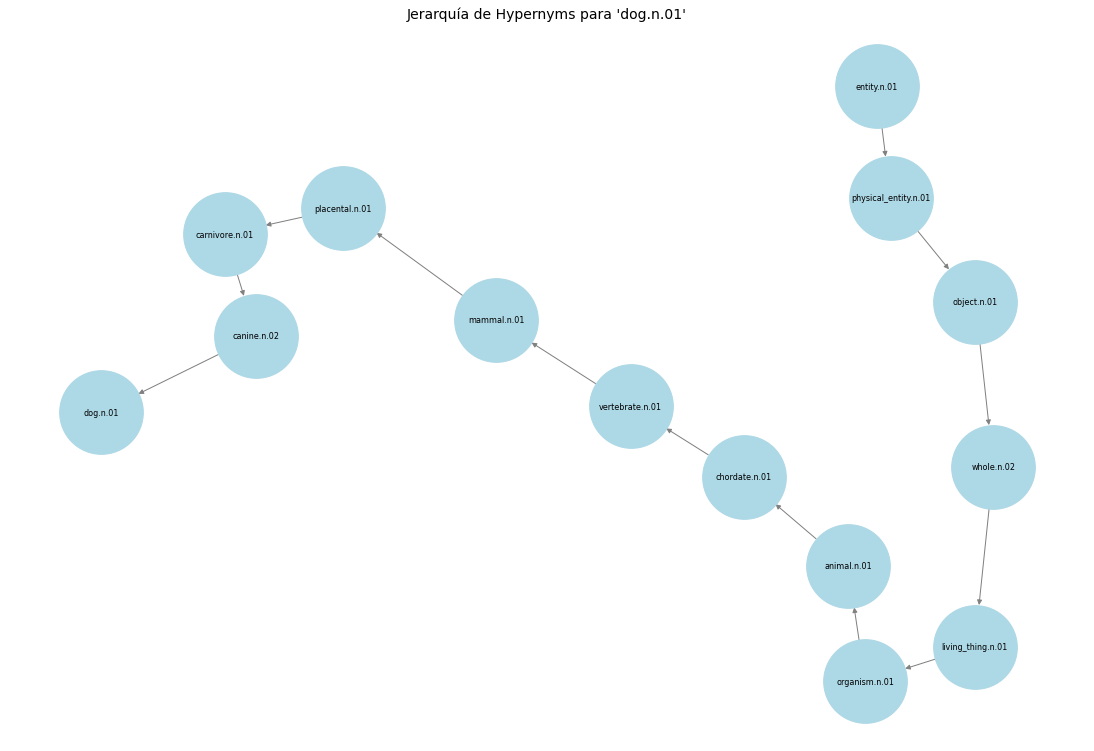

In [7]:
# Crear un grafo
G = nx.DiGraph()

# Añadir nodos y relaciones
for synset in dog.hypernym_paths()[0]:
    G.add_node(synset.name(), label=synset.name())
    if synset.hypernyms():
        G.add_edge(synset.hypernyms()[0].name(), synset.name())

# Configuración del gráfico
plt.figure(figsize=(15, 10))  # Aumentar el tamaño de la figura
pos = nx.spring_layout(G, seed=42)  # Distribución más clara
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=7000,
    node_color="lightblue",
    edge_color="gray",
    font_size=10,
)
# Añadir etiquetas con definiciones más visibles
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, verticalalignment='center')

plt.title("Jerarquía de Hypernyms para 'dog.n.01'", fontsize=14)
plt.show()



Exemple més extens amb animals

In [8]:
# Lista de etiquetas (10 palabras)
image_labels = ['golden_retriever', 'beagle', 'labrador_retriever', 'wolf', 
                'fox', 'cat', 'lion', 'tiger', 'cheetah', 'dog']

# Convertir etiquetas a Synsets (primer Synset de cada palabra)
synsets = [wn.synsets(label, pos=wn.NOUN)[0] for label in image_labels]

# Mostrar los Synsets y sus definiciones
for synset in synsets:
    print(f"Etiqueta: {synset.name()} - {synset.definition()}")


Etiqueta: golden_retriever.n.01 - an English breed having a long silky golden coat
Etiqueta: beagle.n.01 - a small short-legged smooth-coated breed of hound
Etiqueta: labrador_retriever.n.01 - breed originally from Labrador having a short black or golden-brown coat
Etiqueta: wolf.n.01 - any of various predatory carnivorous canine mammals of North America and Eurasia that usually hunt in packs
Etiqueta: fox.n.01 - alert carnivorous mammal with pointed muzzle and ears and a bushy tail; most are predators that do not hunt in packs
Etiqueta: cat.n.01 - feline mammal usually having thick soft fur and no ability to roar: domestic cats; wildcats
Etiqueta: lion.n.01 - large gregarious predatory feline of Africa and India having a tawny coat with a shaggy mane in the male
Etiqueta: tiger.n.01 - a fierce or audacious person
Etiqueta: cheetah.n.01 - long-legged spotted cat of Africa and southwestern Asia having nonretractile claws; the swiftest mammal; can be trained to run down game
Etiqueta: do

In [9]:
# Encontrar el ancestro común más cercano
common_ancestor = synsets[0]  # Empezamos con el primer Synset
for synset in synsets[1:]:    # Iteramos sobre los demás
    common_ancestor = common_ancestor.lowest_common_hypernyms(synset)[0]

# Mostrar el resultado
print("Ancestro común más cercano:")
print(f"  {common_ancestor.name()} - {common_ancestor.definition()}")


Ancestro común más cercano:
  organism.n.01 - a living thing that has (or can develop) the ability to act or function independently


In [10]:
# Ruta hacia la raíz
hypernym_path = common_ancestor.hypernym_paths()[0]

print("Ruta hacia la raíz:")
for hypernym in hypernym_path:
    print(f"  {hypernym.name()} - {hypernym.definition()}")


Ruta hacia la raíz:
  entity.n.01 - that which is perceived or known or inferred to have its own distinct existence (living or nonliving)
  physical_entity.n.01 - an entity that has physical existence
  object.n.01 - a tangible and visible entity; an entity that can cast a shadow
  whole.n.02 - an assemblage of parts that is regarded as a single entity
  living_thing.n.01 - a living (or once living) entity
  organism.n.01 - a living thing that has (or can develop) the ability to act or function independently


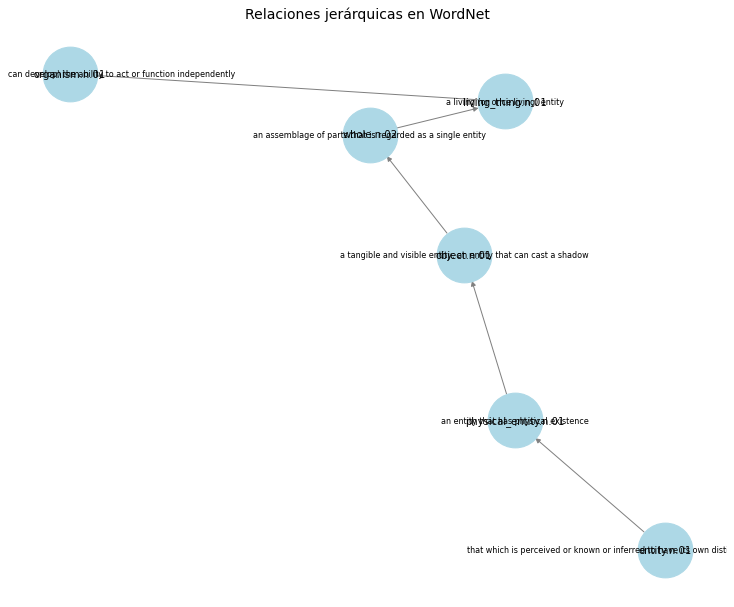

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un grafo
G = nx.DiGraph()

# Añadir nodos y relaciones
for synset in hypernym_path:
    G.add_node(synset.name(), label=synset.definition())
    if synset.hypernyms():
        G.add_edge(synset.hypernyms()[0].name(), synset.name())

# Configurar el gráfico
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color="gray", font_size=10)
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, verticalalignment='center')

plt.title("Relaciones jerárquicas en WordNet", fontsize=14)
plt.show()


## Similaritats entre les definicions

In [12]:
# Definiciones de los Synsets
definitions = [synset.definition() for synset in synsets]

# Calcular vectores TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(definitions)

# Calcular similitud coseno entre las definiciones
similarity_matrix = cosine_similarity(tfidf_matrix)
print("Matriz de similitud:")
print(similarity_matrix)


Matriz de similitud:
[[1.         0.09032877 0.31070855 0.         0.         0.04116789
  0.1054667  0.         0.10414647 0.        ]
 [0.09032877 1.         0.17519629 0.07654285 0.         0.
  0.03958876 0.         0.10041574 0.02964475]
 [0.31070855 0.17519629 1.         0.         0.         0.03461853
  0.08868811 0.12962067 0.02872    0.05298597]
 [0.         0.07654285 0.         1.         0.25748113 0.08343271
  0.17162625 0.         0.06809628 0.09825884]
 [0.         0.         0.         0.25748113 1.         0.08697805
  0.1285766  0.         0.07215818 0.05112363]
 [0.04116789 0.         0.03461853 0.08343271 0.08697805 1.
  0.11460694 0.         0.13225882 0.        ]
 [0.1054667  0.03958876 0.08868811 0.17162625 0.1285766  0.11460694
  1.         0.         0.15539098 0.11366035]
 [0.         0.         0.12962067 0.         0.         0.
  0.         1.         0.         0.        ]
 [0.10414647 0.10041574 0.02872    0.06809628 0.07215818 0.13225882
  0.15539098 0.

In [13]:
# Generar resumen simple
def generate_summary(synsets):
    definitions = [synset.definition() for synset in synsets]
    summary = " Esta neurona responde a conceptos como: " + ", ".join(definitions)
    return summary

# Ejemplo
summary = generate_summary(synsets)
print(summary)


 Esta neurona responde a conceptos como: an English breed having a long silky golden coat, a small short-legged smooth-coated breed of hound, breed originally from Labrador having a short black or golden-brown coat, any of various predatory carnivorous canine mammals of North America and Eurasia that usually hunt in packs, alert carnivorous mammal with pointed muzzle and ears and a bushy tail; most are predators that do not hunt in packs, feline mammal usually having thick soft fur and no ability to roar: domestic cats; wildcats, large gregarious predatory feline of Africa and India having a tawny coat with a shaggy mane in the male, a fierce or audacious person, long-legged spotted cat of Africa and southwestern Asia having nonretractile claws; the swiftest mammal; can be trained to run down game, a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric times; occurs in many breeds


## TASCA 1

- Ens ve la informació per carpetes:
    - 1 Llistes TFG
        - 2 Capes
            - 3 Neurones de cada capa
                - 4 Top 100 imatges de cada una de les neurones

Llegir la informació de les llistes que ens han donat i crar un mapping per a poder tindre en forma de classe de imagenet per a poder fer una posterior cerca

Definiré diferntes funcions:
- 1 Llegir els documents
- 2 Crear el mapping
- 3 Crear nou document amb els synsets de l'imagenet

## Funcio 1 : Mapping de codigo de image net a wordnet.

- Tenim un fitxer txt on tenim informació de :
    - id : nom a l'imagenet.
- Volem fer un mapping amb aquesta informació per a poder passar-ho de manera correcta a la llista amb les imatges que ens donen

1.Leer los archivos guardado en formado array

In [14]:
import numpy as np

In [15]:
layer1= np.load("../Data/layer1.npy")
print(layer1)
layer1.size


[['n03832673/n03832673_11987.JPEG' 'n03196217/n03196217_4377.JPEG'
  'n02672831/n02672831_491.JPEG' ... 'n04081281/n04081281_11244.JPEG'
  'n03773504/n03773504_8241.JPEG' 'n03602883/n03602883_9260.JPEG']
 ['n03345487/n03345487_9095.JPEG' 'n03895866/n03895866_65760.JPEG'
  'n02704792/n02704792_17843.JPEG' ... 'n07747607/n07747607_26760.JPEG'
  'n04243546/n04243546_3659.JPEG' 'n04367480/n04367480_1560.JPEG']
 ['n04149813/n04149813_8646.JPEG' 'n01806143/n01806143_11962.JPEG'
  'n03871628/n03871628_1178.JPEG' ... 'n02701002/n02701002_4899.JPEG'
  'n02776631/n02776631_96945.JPEG' 'n06794110/n06794110_13211.JPEG']
 ...
 ['n04243546/n04243546_29807.JPEG' 'n04154565/n04154565_24713.JPEG'
  'n04039381/n04039381_4191.JPEG' ... 'n04243546/n04243546_1504.JPEG'
  'n03494278/n03494278_3069.JPEG' 'n04039381/n04039381_8423.JPEG']
 ['n04487394/n04487394_3977.JPEG' 'n04326547/n04326547_3029.JPEG'
  'n02951585/n02951585_1242.JPEG' ... 'n04192698/n04192698_36236.JPEG'
  'n03000684/n03000684_29665.JPEG' 'n

25600

In [19]:
import numpy as np

def extract_wnids_from_layer(layer_matrix):
    """
    Extrae los códigos WNID de una matriz de paths de imágenes activadas por neuronas.

    Args:
        layer_matrix (numpy.ndarray): Matriz donde cada celda es un path de imagen.

    Returns:
        dict: Diccionario {neurona: lista de WNID únicos activados}.
    """
    neuron_wnids = {}

    for neuron_idx, row in enumerate(layer_matrix):  # Iteramos por neuronas
        wnids = {path.split('/')[0] for path in row}  # Extraemos WNID únicos
        neuron_wnids[f"neuron_{neuron_idx}"] = list(wnids)

    return neuron_wnids


In [44]:
neuron_wnids = extract_wnids_from_layer(layer3)

In [45]:
neuron_wnids

{'neuron_0': ['n04355338',
  'n03272562',
  'n03459775',
  'n03871628',
  'n02950826',
  'n01968897',
  'n03538406',
  'n01496331',
  'n02165456',
  'n03888605',
  'n03841143',
  'n01748264',
  'n02859443',
  'n02097298',
  'n07831146',
  'n03633091',
  'n04277352',
  'n03481172',
  'n03134739',
  'n01494475',
  'n02823428',
  'n02086910',
  'n12768682',
  'n01980166',
  'n03895866',
  'n02085620',
  'n04296562',
  'n01558993',
  'n04270147',
  'n02094258',
  'n04597913',
  'n03874293',
  'n02165105',
  'n04536866',
  'n04154565',
  'n02111889',
  'n02776631',
  'n04149813',
  'n02113799',
  'n02364673',
  'n03595614',
  'n03761084',
  'n03534580',
  'n07753113',
  'n07760859',
  'n04209239',
  'n01531178',
  'n07873807',
  'n04525038',
  'n02877765',
  'n03967562',
  'n02454379',
  'n03133878',
  'n03720891',
  'n02097047',
  'n02094114',
  'n02086079',
  'n03388549',
  'n04116512',
  'n03857828',
  'n01518878',
  'n01694178',
  'n03920288',
  'n07565083',
  'n04099969',
  'n01728572'

Layer 2

In [16]:
layer2= np.load("../Data/layer2.npy")
print(layer2)
layer2.size

[['n03871628/n03871628_7500.JPEG' 'n03598930/n03598930_3590.JPEG'
  'n03598930/n03598930_1174.JPEG' ... 'n03662601/n03662601_13675.JPEG'
  'n07718472/n07718472_24515.JPEG' 'n04389033/n04389033_33415.JPEG']
 ['n03197337/n03197337_22252.JPEG' 'n03065424/n03065424_3403.JPEG'
  'n04141076/n04141076_1892.JPEG' ... 'n01924916/n01924916_16244.JPEG'
  'n02102480/n02102480_7690.JPEG' 'n06794110/n06794110_264.JPEG']
 ['n03179701/n03179701_10968.JPEG' 'n02672831/n02672831_59830.JPEG'
  'n11879895/n11879895_9792.JPEG' ... 'n02091134/n02091134_338.JPEG'
  'n02950826/n02950826_10759.JPEG' 'n03733131/n03733131_20069.JPEG']
 ...
 ['n02606052/ILSVRC2012_val_00046491.JPEG'
  'n02877765/n02877765_1872.JPEG' 'n02437312/n02437312_2284.JPEG' ...
  'n02916936/n02916936_976.JPEG' 'n03131574/n03131574_7104.JPEG'
  'n04037443/n04037443_484.JPEG']
 ['n03404251/n03404251_14022.JPEG' 'n04235860/n04235860_2065.JPEG'
  'n03594945/n03594945_27639.JPEG' ... 'n03902125/n03902125_4211.JPEG'
  'n04557648/n04557648_2122.J

51200

Layer 3

In [17]:
layer3= np.load("../Data/layer3.npy")
print(layer3)
layer3.size

[['n03617480/n03617480_5858.JPEG' 'n02094114/n02094114_5130.JPEG'
  'n02834397/n02834397_3465.JPEG' ... 'n01558993/n01558993_14281.JPEG'
  'n02877765/n02877765_10806.JPEG' 'n02859443/n02859443_7278.JPEG']
 ['n02006656/n02006656_1993.JPEG' 'n02701002/n02701002_3855.JPEG'
  'n02037110/n02037110_12075.JPEG' ... 'n02325366/n02325366_4209.JPEG'
  'n01824575/n01824575_5745.JPEG' 'n03995372/n03995372_8648.JPEG']
 ['n02494079/n02494079_6559.JPEG' 'n02493793/n02493793_318.JPEG'
  'n02494079/n02494079_6695.JPEG' ... 'n02107908/n02107908_2921.JPEG'
  'n01820546/n01820546_1112.JPEG' 'n03110669/n03110669_22109.JPEG']
 ...
 ['n02277742/ILSVRC2012_val_00000810.JPEG'
  'n02277742/n02277742_2466.JPEG' 'n07734744/n07734744_3847.JPEG' ...
  'n01914609/n01914609_16078.JPEG' 'n03291819/n03291819_7713.JPEG'
  'n02342885/n02342885_10561.JPEG']
 ['n04033995/n04033995_6350.JPEG' 'n04429376/n04429376_12605.JPEG'
  'n01728572/n01728572_24407.JPEG' ... 'n03954731/n03954731_41255.JPEG'
  'n07697537/n07697537_29885

102400

Layer 4

In [43]:
layer4= np.load("../Data/layer4.npy")
print(layer4)
layer4.size

ValueError: cannot reshape array of size 151283 into shape (2048,100)

Capa relu

In [ ]:
relu= np.load("../Data/relu.npy")
print(relu)
relu.size

[['n02895154/n02895154_44125.JPEG' 'n04505470/n04505470_737.JPEG'
  'n02708093/n02708093_820.JPEG' ... 'n04482393/n04482393_19779.JPEG'
  'n04259630/n04259630_9393.JPEG' 'n03476684/n03476684_7450.JPEG']
 ['n03476684/n03476684_15869.JPEG' 'n04612504/n04612504_932.JPEG'
  'n02979186/ILSVRC2012_val_00042982.JPEG' ...
  'n07753592/n07753592_7937.JPEG' 'n04505470/n04505470_6835.JPEG'
  'n02769748/n02769748_91961.JPEG']
 ['n04118776/n04118776_25340.JPEG' 'n06359193/n06359193_32672.JPEG'
  'n02840245/n02840245_10232.JPEG' ... 'n03425413/n03425413_10117.JPEG'
  'n04120489/n04120489_6296.JPEG' 'n13133613/n13133613_41404.JPEG']
 ...
 ['n04476259/n04476259_13156.JPEG' 'n04149813/n04149813_8265.JPEG'
  'n03876231/n03876231_40750.JPEG' ... 'n03089624/n03089624_13002.JPEG'
  'n02782093/n02782093_4789.JPEG' 'n03944341/n03944341_14151.JPEG']
 ['n03457902/n03457902_25901.JPEG' 'n04243546/n04243546_20408.JPEG'
  'n03874293/n03874293_775.JPEG' ... 'n04357314/n04357314_9099.JPEG'
  'n04243546/n04243546_12

6400

In [22]:
# Creem el file_path on tenim el fitxer txt que volem llegir
file_path = "../Data/Image_net_Classes.txt"

if os.path.exists(file_path):
    print("L'arxiu existeix")
else:
    print("L'arxiu no existeix")

L'arxiu existeix


In [ ]:
def read_wnid_with_labels(file_path):
    """
    Lee un archivo de texto y extrae los WordNet IDs (WNID) junto con su descripción.

    Args:
        file_path (str): Ruta del archivo a leer.

    Returns:
        list of tuples: Lista de (WNID, Descripción).
    """
    wnid_list = []

    if not os.path.exists(file_path):
        print(f"Error: El archivo {file_path} no existe.")
        return wnid_list

    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if line:  
                parts = line.split(":")  # Separar el código del texto
                wnid = parts[0]
                description = parts[1].strip() if len(parts) > 1 else ""
                wnid_list.append((wnid, description))

    return wnid_list


wnid_list = read_wnid_with_labels(file_path)

for wnid, label in wnid_list:
    print(f"{wnid} -> {label}")

n02119789 -> kit fox, Vulpes macrotis
n02100735 -> English setter
n02096294 -> Australian terrier
n02066245 -> grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus
n02509815 -> lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens
n02124075 -> Egyptian cat
n02417914 -> ibex, Capra ibex
n02123394 -> Persian cat
n02125311 -> cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
n02423022 -> gazelle
n02346627 -> porcupine, hedgehog
n02077923 -> sea lion
n02447366 -> badger
n02109047 -> Great Dane
n02092002 -> Scottish deerhound, deerhound
n02071294 -> killer whale, killer, orca, grampus, sea wolf, Orcinus orca
n02442845 -> mink
n02504458 -> African elephant, Loxodonta africana
n02114712 -> red wolf, maned wolf, Canis rufus, Canis niger
n02128925 -> jaguar, panther, Panthera onca, Felis onca
n02117135 -> hyena, hyaena
n02493509 -> titi, titi monkey
n02457408 -> three-toed sloth, ai, Bradypus tridactylus
n02389026 -> sorrel
n024434

Funcion de prueba para mapping genera a synsets

Ahora que tenemos la informacion de los WNIDS del fichero, deberiamos poder pasarlo a Synsets.

In [31]:
def convert_wnid_list_to_dict(wnid_list):
    """
    Convierte una lista de tuplas (WNID, Descripción) en un diccionario.

    Args:
        wnid_list (list of tuples): Lista de (WNID, Descripción).

    Returns:
        dict: Diccionario {WNID: Descripción}.
    """
    return {wnid: description for wnid, description in wnid_list}


In [46]:
wnid_dict = convert_wnid_list_to_dict(wnid_list)

# Mostrar algunos ejemplos
for wnid, description in list(wnid_dict.items())[:5]:
    print(f"{wnid}: {description}")


n02119789: kit fox, Vulpes macrotis
n02100735: English setter
n02096294: Australian terrier
n02066245: grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus
n02509815: lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens


In [47]:
def map_neuron_wnids_to_classes(neuron_wnids, wnid_dict):
    """
    Convierte una lista de WNIDs activados en nombres de clases.

    Args:
        neuron_wnids (dict): Diccionario {neurona: lista de WNIDs}.
        wnid_dict (dict): Diccionario {WNID: Clase}.

    Returns:
        dict: Diccionario {neurona: lista de nombres de clases}.
        dict: Estadísticas de conversión por neurona.
    """
    neuron_classes = {}
    conversion_stats = {}

    for neuron, wnids in neuron_wnids.items():
        classes = [wnid_dict.get(wnid, "Desconocido") for wnid in wnids]  # Mapeamos WNID a clase
        valid_classes = [c for c in classes if c != "Desconocido"]  # Filtramos los no encontrados

        neuron_classes[neuron] = valid_classes

        # Guardamos estadísticas
        conversion_stats[neuron] = {
            "total_wnids": len(wnids),
            "mapped_classes": len(valid_classes),
            "conversion_rate": len(valid_classes) / len(wnids) * 100 if wnids else 0,
            "class_distribution": {c: valid_classes.count(c) / len(valid_classes) * 100 for c in set(valid_classes)}
        }

    return neuron_classes, conversion_stats


In [50]:
# neuron_wnids = {
#     'neuron_255': ['n02119789', 'n01751748', 'n03598930', 'n03000134', 'n03775071']
# }  # Ejemplo reducido

neuron_classes, conversion_stats = map_neuron_wnids_to_classes(neuron_wnids, wnid_dict)

# Mostrar la conversión
for neuron, classes in neuron_classes.items():
    print(f"\n📌 {neuron}: {classes}")



📌 neuron_0: ['sundial', 'electric locomotive', 'grille, radiator grille', 'packet', 'cannon', 'chambered nautilus, pearly nautilus, nautilus', 'horse cart, horse-cart', 'electric ray, crampfish, numbfish, torpedo', 'ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle', 'parallel bars, bars', 'odometer, hodometer, mileometer, milometer', 'Indian cobra, Naja naja', 'boathouse', 'Scotch terrier, Scottish terrier, Scottie', 'carbonara', 'ladle', 'spindle', 'hammer', 'croquet ball', 'hammerhead, hammerhead shark', 'beer bottle', 'papillon', 'buckeye, horse chestnut, conker', 'fiddler crab', 'passenger car, coach, carriage', 'Chihuahua', 'stage', 'robin, American robin, Turdus migratorius', 'spatula', 'Norwich terrier', 'wooden spoon', 'paddlewheel, paddle wheel', 'tiger beetle', 'violin, fiddle', 'screwdriver', 'Samoyed, Samoyede', 'bakery, bakeshop, bakehouse', 'scoreboard', 'standard poodle', 'guinea pig, Cavia cobaya', 'jersey, T-shirt, tee shirt', 'microwave, microwave oven', '

In [ ]:
def display_conversion_stats(conversion_stats):
    """
    Muestra estadísticas de conversión de WNIDs a clases por neurona.

    Args:
        conversion_stats (dict): Diccionario de estadísticas {neurona: datos}.
    """
    for neuron, stats in conversion_stats.items():
        print(f"\n Neurona: {neuron}")
        print(f"   - WNIDs totales: {stats['total_wnids']}")
        print(f"   - WNIDs convertidos a clases: {stats['mapped_classes']}")
        print(f"   - Tasa de conversión: {stats['conversion_rate']:.2f}%")

        print("   - Distribución de clases:")
        sorted_classes = sorted(stats['class_distribution'].items(), key=lambda x: x[1], reverse=True)

        for cls, pct in sorted_classes[:5]:  # Mostrar solo las 5 clases más comunes
            print(f"     🔹 {cls}: {pct:.2f}%")

# Ejecutar el análisis
display_conversion_stats(conversion_stats)



📌 Neurona: neuron_0
   - WNIDs totales: 94
   - WNIDs convertidos a clases: 94
   - Tasa de conversión: 100.00%
   - Distribución de clases:
     🔹 fiddler crab: 1.06%
     🔹 sundial: 1.06%
     🔹 wooden spoon: 1.06%
     🔹 electric ray, crampfish, numbfish, torpedo: 1.06%
     🔹 Pembroke, Pembroke Welsh corgi: 1.06%

📌 Neurona: neuron_1
   - WNIDs totales: 49
   - WNIDs convertidos a clases: 49
   - Tasa de conversión: 100.00%
   - Distribución de clases:
     🔹 American coot, marsh hen, mud hen, water hen, Fulica americana: 2.04%
     🔹 Saint Bernard, St Bernard: 2.04%
     🔹 coucal: 2.04%
     🔹 baboon: 2.04%
     🔹 Angora, Angora rabbit: 2.04%

📌 Neurona: neuron_2
   - WNIDs totales: 70
   - WNIDs convertidos a clases: 70
   - Tasa de conversión: 100.00%
   - Distribución de clases:
     🔹 hard disc, hard disk, fixed disk: 1.43%
     🔹 mountain tent: 1.43%
     🔹 three-toed sloth, ai, Bradypus tridactylus: 1.43%
     🔹 bottlecap: 1.43%
     🔹 waffle iron: 1.43%

📌 Neurona: neuron_

In [61]:
from collections import Counter

from collections import Counter

def analyze_class_distribution_across_layer(conversion_stats):
    """
    Analiza la distribución de clases en toda la capa sumando las activaciones reales,
    y luego normaliza los valores dividiéndolos entre el total de activaciones.

    Args:
        conversion_stats (dict): Diccionario de estadísticas de conversión {neurona: datos}.

    Returns:
        dict: Distribución de clases en la capa con porcentajes normalizados.
    """
    global_class_counts = Counter()
    total_activations = 0  # Contador global de activaciones reales

    for stats in conversion_stats.values():
        class_counts = stats["class_distribution"]  # Diccionario {clase: frecuencia en % dentro de la neurona}
        
        for class_name, freq in class_counts.items():
            # Convertir la frecuencia relativa en número absoluto de activaciones
            real_count = (freq / 100) * stats["mapped_classes"]
            global_class_counts[class_name] += real_count
            total_activations += real_count  # Sumamos al total global

    # Si no hay activaciones, retornamos un diccionario vacío para evitar división por cero
    if total_activations == 0:
        print("⚠️ No hay activaciones registradas en esta capa.")
        return {}

    # Normalizar dividiendo entre el total de activaciones
    normalized_class_distribution = {
        class_name: (freq / total_activations) * 100 for class_name, freq in global_class_counts.items()
    }

    return normalized_class_distribution
# Obtener la nueva distribución de clases con los valores corregidos
layer_class_distribution = analyze_class_distribution_across_layer(conversion_stats)

# Mostrar las 10 clases más comunes en la capa
print("📌 Clases más comunes en toda la capa:")
for class_name, freq in sorted(layer_class_distribution.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"   🔹 {class_name}: {freq:.2f}%")

# Verificar que la suma de los porcentajes ahora sea correcta
total_percentage = sum(layer_class_distribution.values())
print(f"📌 Suma total de porcentajes: {total_percentage:.2f}%")



📌 Clases más comunes en toda la capa:
   🔹 plunger, plumber's helper: 0.21%
   🔹 crane: 0.20%
   🔹 sombrero: 0.20%
   🔹 traffic light, traffic signal, stoplight: 0.20%
   🔹 microphone, mike: 0.20%
   🔹 joystick: 0.19%
   🔹 cello, violoncello: 0.19%
   🔹 ice lolly, lolly, lollipop, popsicle: 0.19%
   🔹 drumstick: 0.19%
   🔹 maraca: 0.19%
📌 Suma total de porcentajes: 100.00%


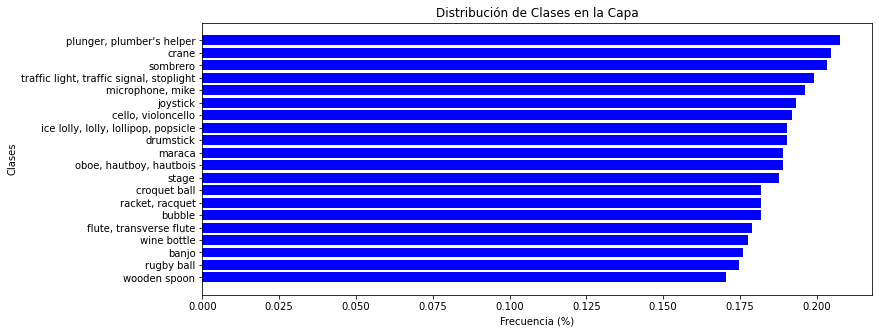

In [63]:
import matplotlib.pyplot as plt

def plot_layer_class_distribution(layer_class_distribution):
    """
    Grafica la distribución de clases en toda la capa.

    Args:
        layer_class_distribution (dict): Diccionario {clase: porcentaje}.
    """
    # Ordenar el diccionario por los valores (porcentaje) de mayor a menor
    top_classes = sorted(layer_class_distribution.items(), key=lambda x: x[1], reverse=True)[:20]

    # Separar nombres de clases y porcentajes
    class_names, percentages = zip(*top_classes)

    # Crear el gráfico
    plt.figure(figsize=(12, 5))
    plt.barh(class_names[::-1], percentages[::-1], color="blue")  # Invertimos para mejor visualización
    plt.xlabel("Frecuencia (%)")
    plt.ylabel("Clases")
    plt.title("Distribución de Clases en la Capa")
    plt.show()

# Ejecutar la visualización
plot_layer_class_distribution(layer_class_distribution)


In [64]:
import numpy as np

def compute_entropy(class_distribution):
    """
    Calcula la entropía de una distribución de clases.

    Args:
        class_distribution (dict): Diccionario {clase: frecuencia relativa}.

    Returns:
        float: Entropía de la distribución.
    """
    probs = np.array(list(class_distribution.values())) / 100  # Convertimos a proporciones
    return -np.sum(probs * np.log2(probs)) if len(probs) > 0 else 0

def analyze_entropy_per_neuron(conversion_stats):
    """
    Calcula la entropía de cada neurona en la capa.

    Args:
        conversion_stats (dict): Diccionario de estadísticas de conversión.

    Returns:
        dict: Diccionario {neurona: entropía}.
    """
    entropy_per_neuron = {
        neuron: compute_entropy(stats["class_distribution"])
        for neuron, stats in conversion_stats.items()
    }
    return entropy_per_neuron

# Calcular entropía de cada neurona
neuron_entropy = analyze_entropy_per_neuron(conversion_stats)

# Mostrar las 10 neuronas con menor entropía (más especializadas)
print("\n📌 Neuronas más especializadas (menor entropía):")
for neuron, entropy in sorted(neuron_entropy.items(), key=lambda x: x[1])[:10]:
    print(f"   🔹 {neuron}: {entropy:.3f}")



📌 Neuronas más especializadas (menor entropía):
   🔹 neuron_348: 3.459
   🔹 neuron_869: 3.459
   🔹 neuron_512: 3.700
   🔹 neuron_554: 3.907
   🔹 neuron_951: 4.000
   🔹 neuron_975: 4.087
   🔹 neuron_9: 4.248
   🔹 neuron_353: 4.248
   🔹 neuron_919: 4.248
   🔹 neuron_971: 4.248


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def compare_class_distribution_across_layers(layer_stats):
    """
    Compara la distribución de clases entre diferentes capas.

    Args:
        layer_stats (dict): Diccionario {capa: conversion_stats}.

    Returns:
        dict: Diccionario {capa: Counter(clase: frecuencia)}.
    """
    layer_class_counts = {}

    for layer_name, conversion_stats in layer_stats.items():
        global_class_counts = Counter()

        for stats in conversion_stats.values():
            for class_name, freq in stats["class_distribution"].items():
                global_class_counts[class_name] += freq / 100  # Convertimos porcentaje a proporción

        layer_class_counts[layer_name] = global_class_counts

    return layer_class_counts

# Suponiendo que tenemos conversion_stats para varias capas

layer_class_counts = compare_class_distribution_across_layers(layer_stats)
